### In this project we are going to scrape the data from https://layoffs.fyi/, store them in a sql database, normalize the database, load the tables in power bi and create a monitoring dashboard that we will be available for long term studies

#### First step is to get the data from the site. Unfortunately, there is no api for this table. Even though there are more efficient ways to get the data - like the airtable extenstion (paid service) or even printing/saving the data as pdf and then converting to csv, which works doesn't work very well for free converters - I wanted to get the data programmaticaly for free. This iteration process was insired from this medium article https://medium.com/@aishwaryagautam/navigating-layoffs-a-comprehensive-data-analysis-0295594ede87, and we are using the selenium and beautifulsoup. One of the difficulties is that the html code updates dynamically. One iteration gives about 30% of the rows, 10 about 90% and we can get almost 100% after about 30 iterations. The goal however is to respect the site and just do about 5 iterrations once a week and update the data we already have.

In [2]:
# Import all necessary libraries
from bs4 import BeautifulSoup
from selenium import webdriver
import time
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
import re
import pandas as pd
import random
from datetime import datetime, timedelta
import os

def scrape_airtable(num_iterations=2):
    # List to store all dataframes
    dfs = []
    
    # Track total time
    total_start_time = time.time()
    
    for iteration in range(num_iterations):
        # Start timing this iteration
        iteration_start_time = time.time()
        print(f"\nStarting iteration {iteration + 1}/{num_iterations}")
        print(f"Start time: {datetime.now().strftime('%H:%M:%S')}")
        
        # Your original code starts here
        driver = webdriver.Chrome()
        driver.get("https://airtable.com/app1PaujS9zxVGUZ4/shrqYt5kSqMzHV9R5/tbl8c8kanuNB6bPYr?viewControls=on")
        driver.maximize_window()
        time.sleep(random.uniform(2, 4))
        
        scrollbar_xpath = "//*[@id='view']/div/div[1]/div[1]/div[3]"
        element = driver.find_element(By.XPATH, scrollbar_xpath)
        leftPane = []
        rightPane = []
        i = 0
        while i < 120:
            scroll_distance = random.uniform(1, 5)
            scroll_duration = random.uniform(0.1, 0.5)
            
            if random.random() < 0.05:
                time.sleep(random.uniform(2, 4))
            
            ActionChains(driver).click_and_hold(element)\
                .move_by_offset(0, scroll_distance)\
                .pause(scroll_duration)\
                .perform()
            ActionChains(driver).reset_actions()
            
            time.sleep(random.uniform(0.8, 2.5))
            
            html = driver.page_source
            parsed_html = BeautifulSoup(html, "html.parser")
            leftPane.append(parsed_html.find_all('div',class_='dataRow leftPane rowExpansionEnabled rowSelectionEnabled'))
            rightPane.append(parsed_html.find_all('div',class_='dataRow rightPane rowExpansionEnabled rowSelectionEnabled'))
            i = i+1
            
        dictionary = {}
        for i in range(len(leftPane)):
            for j in range(len(leftPane[i])):
                pattern = r'<div[^>]*class="[^"]*line-height-4[^"]*overflow-hidden[^"]*truncate[^"]*"[^>]*>(.*?)<\/div>'
                match = re.search(pattern, str(leftPane[i][j]))
                dictionary[str(leftPane[i][j])[70:100]] = [str(match.group(1))]
                
        for i in range(len(rightPane)):
            for j in range(len(rightPane[i])):
                if str(rightPane[i][j])[71:101] in dictionary:
                    pattern = r'<div class="flex-auto truncate-pre" title="(.*?)">'
                    match = re.findall(pattern, str(rightPane[i][j]))
                    dictionary[str(rightPane[i][j])[71:101]].append(match)
                    pattern = r'<div class="flex-auto truncate line-height-4 right-align tabular-nums" style="padding:6px">(.*?)</div>'
                    match = re.findall(pattern, str(rightPane[i][j]))
                    try: 
                        dictionary[str(rightPane[i][j])[71:101]].append(match)
                    except Exception:
                        dictionary[str(rightPane[i][j])[71:101]].append('')
                    pattern = r'div class="truncate css-10jy3hn">(.*?)</div>'
                    match = re.search(pattern, str(rightPane[i][j]))
                    dictionary[str(rightPane[i][j])[71:101]].append(match.group(1))
                    
        data = []
        for i in dictionary.keys():
            if len(dictionary[i][2]) != 0:
                x,y,z = '','',''
                if '%' in dictionary[i][2][0]:
                    y = dictionary[i][2][0]
                    if len(dictionary[i][2]) > 1:
                        z = dictionary[i][2][1]
                elif '$' in dictionary[i][2][0]:
                    z = dictionary[i][2][0]
                else:
                    x = dictionary[i][2][0]
                    if len(dictionary[i][2]) > 1:
                        if '%' in dictionary[i][2][1]:
                            y = dictionary[i][2][1]
                            if len(dictionary[i][2]) > 2:
                                z = dictionary[i][2][2]
                        else:
                            z = dictionary[i][2][1]
                data.append([dictionary[i][0],dictionary[i][1][0],x,dictionary[i][3],y,dictionary[i][1][-3],dictionary[i][1][-2],z,dictionary[i][1][-1]])
        
        df = pd.DataFrame(data, columns=['Company', 'Location HQ', '# Laid Off', 'Date', '%', 'Industry', 'Stage', '$ Raised (mm)', 'Country'])
        dfs.append(df)
        
        # Calculate time taken for this iteration
        iteration_time = time.time() - iteration_start_time
        iteration_time_formatted = str(timedelta(seconds=int(iteration_time)))
        
        print(f"Shape of iteration {iteration + 1}: {df.shape}")
        print(f"Time taken for iteration {iteration + 1}: {iteration_time_formatted}")
        print(f"End time: {datetime.now().strftime('%H:%M:%S')}")
        
        driver.quit()
        
        # Add a random delay between iterations
        if iteration < num_iterations - 1:  # Don't delay after the last iteration
            delay = random.uniform(3, 6)
            print(f"Waiting {delay:.1f} seconds before next iteration...\n")
            time.sleep(delay)
    
    # Calculate total time
    total_time = time.time() - total_start_time
    total_time_formatted = str(timedelta(seconds=int(total_time)))
    
    # Combine all dataframes
    final_df = pd.concat(dfs)
    print("\n=== Final Results ===")
    print(f"Total time elapsed: {total_time_formatted}")
    print(f"Shape before dropping duplicates: {final_df.shape}")
    
    # Remove duplicates
    final_df = final_df.drop_duplicates()
    print(f"Shape after dropping duplicates: {final_df.shape}")
    
    # Save to CSV with datetime in filename
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f'scraped_layoffs_{timestamp}.csv'
    final_df.to_csv(filename, index=False)
    print(f"\nData saved to '{filename}'")
    
    return final_df, filename

def merge_layoffs_data(new_file):
    """
    Merges newly scraped data with existing layoffs data file.
    Args:
        new_file (str): Path to the newly created CSV file
    Returns:
        pd.DataFrame: Merged and deduplicated dataframe
    """
    # Read the newly scraped data
    new_data = pd.read_csv(new_file)
    
    # Check if the main layoffs data file exists
    main_file = 'layoffs_data.csv'
    if os.path.exists(main_file):
        # Read existing data
        existing_data = pd.read_csv(main_file)
        
        # Concatenate the dataframes
        merged_df = pd.concat([existing_data, new_data], ignore_index=True)
        
        # Drop duplicates
        merged_df = merged_df.drop_duplicates()
        
        print(f"\n=== Merge Results ===")
        print(f"Existing records: {len(existing_data)}")
        print(f"New records: {len(new_data)}")
        print(f"Total after merge and deduplication: {len(merged_df)}")
        
    else:
        print("\nNo existing layoffs_data.csv found. Creating new file.")
        merged_df = new_data
    
    # Save the merged data, overwriting the existing file
    merged_df.to_csv(main_file, index=False)
    print(f"Updated data saved to '{main_file}'")
    
    return merged_df

# Run the scraper and merge the data
if __name__ == "__main__":
    # Run the scraper
    final_df, new_filename = scrape_airtable()
    
    # Merge the data
    merged_df = merge_layoffs_data(new_filename)


Starting iteration 1/2
Start time: 10:33:46
Shape of iteration 1: (1256, 9)
Time taken for iteration 1: 0:10:34
End time: 10:44:20
Waiting 5.8 seconds before next iteration...


Starting iteration 2/2
Start time: 10:44:28
Shape of iteration 2: (1236, 9)
Time taken for iteration 2: 0:06:26
End time: 10:50:55

=== Final Results ===
Total time elapsed: 0:17:11
Shape before dropping duplicates: (2492, 9)
Shape after dropping duplicates: (1958, 9)

Data saved to 'scraped_layoffs_20241125_105058.csv'

=== Merge Results ===
Existing records: 3738
New records: 1958
Total after merge and deduplication: 3779
Updated data saved to 'layoffs_data.csv'


In [4]:
data = pd.read_csv("layoffs_data.csv")
data

,Company,Location HQ,# Laid Off,Date,%,Industry,Stage,$ Raised (mm),Country
0,Upwork,SF Bay Area,NaN,10/23/2024,21%,Other,Post-IPO,$168,United States
1,Venminder,Louisville,100.0,10/21/2024,NaN,Security,Acquired,$49,United States
2,Jellysmack,New York City,22.0,10/21/2024,NaN,Media,Series C,$22,France
3,Chief,New York City,NaN,10/20/2024,NaN,HR,Series B,$140,United States
4,CapWay,Atlanta,NaN,10/17/2024,100%,Finance,Unknown,NaN,United States
...,...,...,...,...,...,...,...,...,...
3774,VSCO,SF Bay Area,45.0,4/14/2020,35%,Consumer,Series B,$90,United States
3775,Skillz,SF Bay Area,21.0,4/14/2020,NaN,Consumer,Series D,$132,United States
3776,DataStax,SF Bay Area,15.0,4/14/2020,NaN,Data,Series E,$190,United States
3777,Xerpa,Sao Paulo,10.0,4/14/2020,NaN,HR,Unknown,$5,Brazil


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3779 entries, 0 to 3778
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Company        3779 non-null   object 
 1   Location HQ    3779 non-null   object 
 2   # Laid Off     2521 non-null   float64
 3   Date           3779 non-null   object 
 4   %              2480 non-null   object 
 5   Industry       3779 non-null   object 
 6   Stage          3779 non-null   object 
 7   $ Raised (mm)  3441 non-null   object 
 8   Country        3779 non-null   object 
dtypes: float64(1), object(8)
memory usage: 265.8+ KB


In [6]:
# sort by date
data['Date'] = pd.to_datetime(data['Date'])

In [8]:
data = data.sort_values('Date', ascending= False)

In [9]:
data

,Company,Location HQ,# Laid Off,Date,%,Industry,Stage,$ Raised (mm),Country
1633,Lyra Health,SF Bay Area,77.0,2024-11-12,2%,Healthcare,Series F,$910,United States
1635,Stoa,Bengaluru,NaN,2024-11-12,100%,Education,Seed,NaN,India
1634,New Relic,SF Bay Area,NaN,2024-11-12,NaN,Infrastructure,Acquired,$214,United States
1631,Chegg,SF Bay Area,319.0,2024-11-12,21%,Education,Post-IPO,$227,United States
1632,Forward,SF Bay Area,200.0,2024-11-12,100%,Healthcare,Series E,$325,United States
...,...,...,...,...,...,...,...,...,...
3623,Service,Los Angeles,NaN,2020-03-16,100%,Travel,Seed,$5,United States
3625,Panda Squad,SF Bay Area,6.0,2020-03-13,75%,Consumer,Seed,$1,United States
3624,HopSkipDrive,Los Angeles,8.0,2020-03-13,10%,Transportation,Unknown,$45,United States
3626,Tamara Mellon,Los Angeles,20.0,2020-03-12,40%,Retail,Series C,$90,United States


In [12]:
data.to_csv("layoffs_data.csv", index=False)

### Next step is to clean and upload the csv in a mysql server as a staging table.

In [45]:
import os
import pandas as pd
from sqlalchemy import create_engine
import sqlalchemy  # Ensure SQLAlchemy is fully imported for the types module
from sqlalchemy import types
from dotenv import load_dotenv
from sqlalchemy.sql import text  

# Load environment variables from a .env file
load_dotenv()

# Fetch credentials from environment variables
MYSQL_HOST = os.getenv("MYSQL_HOST", "localhost")
MYSQL_USER = os.getenv("MYSQL_USER", "root")
MYSQL_PASSWORD = os.getenv("MYSQL_PASSWORD")
DATABASE_NAME = "layoffs_db"
CSV_FILE_PATH = "layoffs_data.csv"  # Update this with the actual path to your CSV file

def create_database():
    """Create the database if it doesn't exist."""
    try:
        conn = mysql.connector.connect(
            host=MYSQL_HOST,
            user=MYSQL_USER,
            password=MYSQL_PASSWORD
        )
        cursor = conn.cursor()
        
        # Create the database
        cursor.execute(f"CREATE DATABASE IF NOT EXISTS {DATABASE_NAME}")
        print(f"Database '{DATABASE_NAME}' created or verified successfully!")
        
    except mysql.connector.Error as err:
        print(f"Database creation failed: {err}")
    finally:
        if 'conn' in locals() and conn.is_connected():
            cursor.close()
            conn.close()

def load_data():
    """Load CSV data into MySQL."""
    try:
        # Create SQLAlchemy engine
        engine = create_engine(
            f'mysql+pymysql://{MYSQL_USER}:{MYSQL_PASSWORD.replace("@", "%40")}@{MYSQL_HOST}/{DATABASE_NAME}',
            echo=False
        )

        # Load CSV file into DataFrame
        df = pd.read_csv(CSV_FILE_PATH)

        # Clean column names
        df.columns = (
            df.columns
            .str.strip()
            .str.replace(' ', '', regex=True)
            .str.replace('#', 'num', regex=True)
            .str.replace('%', 'Percent', regex=True)  # Rename '%' to 'Percent'
            .str.replace(r'\$', '', regex=True)  # Remove '$' from column names
            .str.replace(r'[^a-zA-Z0-9_]', '', regex=True)  # Remove any other invalid characters
        )

        # Data Cleaning
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Convert Date to datetime
        df['Percent'] = df['Percent'].str.rstrip('%').astype(float)  # Clean 'Percent' and convert to float
        df['Raisedmm'] = df['Raisedmm'].str.replace('[\$,]', '', regex=True).astype(float)  # Clean and convert

        # Add 'id' column based on earliest date
        df = df.sort_values(by='Date').reset_index(drop=True)
        df['id'] = df.index + 1  # Create ID starting from 1 based on sorted Date

        # Reorder columns to put 'id' first
        cols = ['id'] + [col for col in df.columns if col != 'id']
        df = df[cols]

        # Sort by Date in descending order
        df = df.sort_values(by='Date', ascending=False)

        # Load data into MySQL
        df.to_sql(
            name='staging_layoffs',
            con=engine,
            if_exists='replace',
            index=False,
            dtype={
                'id': sqlalchemy.types.Integer,
                'Company': sqlalchemy.types.String(255),
                'Location_HQ': sqlalchemy.types.String(255),
                'num_Laid_Off': sqlalchemy.types.Float,
                'Date': sqlalchemy.types.Date,
                'Percent': sqlalchemy.types.Float,  # Updated column name
                'Industry': sqlalchemy.types.String(255),
                'Stage': sqlalchemy.types.String(255),
                'Raisedmm': sqlalchemy.types.Float,  # Updated column name
                'Country': sqlalchemy.types.String(255)
            }
        )

        print("Data loaded successfully!")
        
        # Preview loaded data
        with engine.connect() as conn:
            query = text("SELECT * FROM staging_layoffs LIMIT 5")  # Use text for raw SQL
            result = conn.execute(query)
            for row in result:
                print(row)

    except Exception as e:
        print(f"Data loading failed: {e}")


if __name__ == "__main__":
    # Create database
    create_database()
    
    # Load data into the database
    load_data()


Database 'layoffs_db' created or verified successfully!
Data loaded successfully!
(3779, 'Lyra Health', 'SF Bay Area', 77.0, datetime.date(2024, 11, 12), 2.0, 'Healthcare', 'Series F', 910.0, 'United States')
(3778, 'Stoa', 'Bengaluru', None, datetime.date(2024, 11, 12), 100.0, 'Education', 'Seed', None, 'India')
(3777, 'New Relic', 'SF Bay Area', None, datetime.date(2024, 11, 12), None, 'Infrastructure', 'Acquired', 214.0, 'United States')
(3776, 'Chegg', 'SF Bay Area', 319.0, datetime.date(2024, 11, 12), 21.0, 'Education', 'Post-IPO', 227.0, 'United States')
(3775, 'Forward', 'SF Bay Area', 200.0, datetime.date(2024, 11, 12), 100.0, 'Healthcare', 'Series E', 325.0, 'United States')


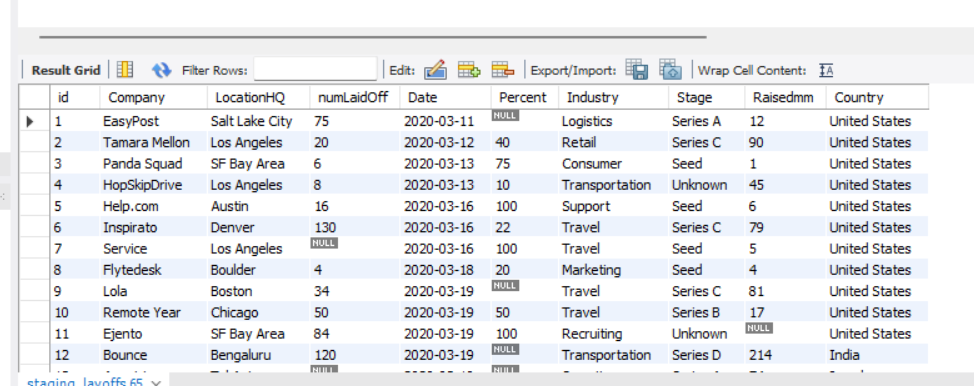


In [66]:
from sqlalchemy import create_engine, text
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Fetch credentials from environment variables
MYSQL_HOST = os.getenv("MYSQL_HOST", "localhost")
MYSQL_USER = os.getenv("MYSQL_USER", "root")
MYSQL_PASSWORD = os.getenv("MYSQL_PASSWORD")
DATABASE_NAME = "layoffs_db"

def normalize_data():
    """Normalize the staging data into multiple normalized tables."""
    try:
        # Create SQLAlchemy engine
        engine = create_engine(
            f'mysql+pymysql://{MYSQL_USER}:{MYSQL_PASSWORD.replace("@", "%40")}@{MYSQL_HOST}/{DATABASE_NAME}',
            echo=False
        )

        with engine.connect() as conn:
            # Start transaction
            with conn.begin():
                # Step 1: Create companies table
                conn.execute(text("""
                    CREATE TABLE IF NOT EXISTS companies (
                        id INT AUTO_INCREMENT PRIMARY KEY,
                        company_name VARCHAR(255) UNIQUE NOT NULL
                    );
                """))

                # Step 2: Create locations table
                conn.execute(text("""
                    CREATE TABLE IF NOT EXISTS locations (
                        id INT AUTO_INCREMENT PRIMARY KEY,
                        location_name TEXT NOT NULL,
                        UNIQUE KEY location_name_unique (location_name(255))
                    );
                """))

                # Step 3: Create industries table
                conn.execute(text("""
                    CREATE TABLE IF NOT EXISTS industries (
                        id INT AUTO_INCREMENT PRIMARY KEY,
                        industry_name VARCHAR(255) UNIQUE NOT NULL
                    );
                """))

                # Step 4: Create stages table
                conn.execute(text("""
                    CREATE TABLE IF NOT EXISTS stages (
                        id INT AUTO_INCREMENT PRIMARY KEY,
                        stage_name VARCHAR(255) UNIQUE NOT NULL
                    );
                """))

                # Step 5: Create layoffs table
                conn.execute(text("""
                    CREATE TABLE IF NOT EXISTS layoffs (
                        id INT AUTO_INCREMENT PRIMARY KEY,
                        company_id INT,
                        location_id INT,
                        industry_id INT,
                        stage_id INT,
                        num_laid_off DOUBLE,
                        date DATE,
                        percent FLOAT,
                        raised_mm FLOAT,
                        country VARCHAR(255),
                        FOREIGN KEY (company_id) REFERENCES companies(id),
                        FOREIGN KEY (location_id) REFERENCES locations(id),
                        FOREIGN KEY (industry_id) REFERENCES industries(id),
                        FOREIGN KEY (stage_id) REFERENCES stages(id)
                    );
                """))

                print("Tables created successfully!")

                # Step 6: Insert data into normalized tables
                # Insert unique companies
                conn.execute(text("""
                    INSERT IGNORE INTO companies (company_name)
                    SELECT DISTINCT Company 
                    FROM staging_layoffs
                    WHERE Company IS NOT NULL;
                """))

                # Insert unique locations
                conn.execute(text("""
                    INSERT IGNORE INTO locations (location_name)
                    SELECT DISTINCT LocationHQ 
                    FROM staging_layoffs
                    WHERE LocationHQ IS NOT NULL;
                """))

                # Insert unique industries
                conn.execute(text("""
                    INSERT IGNORE INTO industries (industry_name)
                    SELECT DISTINCT Industry 
                    FROM staging_layoffs
                    WHERE Industry IS NOT NULL;
                """))

                # Insert unique stages
                conn.execute(text("""
                    INSERT IGNORE INTO stages (stage_name)
                    SELECT DISTINCT Stage 
                    FROM staging_layoffs
                    WHERE Stage IS NOT NULL;
                """))

                # Step 7: Insert layoff records
                conn.execute(text("""
                    INSERT INTO layoffs (
                        company_id, 
                        location_id, 
                        industry_id, 
                        stage_id, 
                        num_laid_off, 
                        date, 
                        percent, 
                        raised_mm, 
                        country
                    )
                    SELECT
                        c.id AS company_id,
                        l.id AS location_id,
                        i.id AS industry_id,
                        s.id AS stage_id,
                        sl.numLaidOff,
                        sl.Date,
                        sl.Percent,
                        sl.Raisedmm,
                        sl.Country
                    FROM staging_layoffs sl
                    JOIN companies c ON sl.Company = c.company_name
                    JOIN locations l ON sl.LocationHQ = l.location_name
                    JOIN industries i ON sl.Industry = i.industry_name
                    JOIN stages s ON sl.Stage = s.stage_name;
                """))

                print("Data normalized and transferred successfully!")

                # Verify the data transfer
                for table in ['companies', 'locations', 'industries', 'stages', 'layoffs']:
                    result = conn.execute(text(f"SELECT COUNT(*) FROM {table}"))
                    count = result.scalar()
                    print(f"Records in {table}: {count}")

    except Exception as e:
        print(f"Normalization failed: {e}")
        raise

if __name__ == "__main__":
    normalize_data()

Tables created successfully!
Data normalized and transferred successfully!
Records in companies: 2644
Records in locations: 241
Records in industries: 34
Records in stages: 21
Records in layoffs: 3779


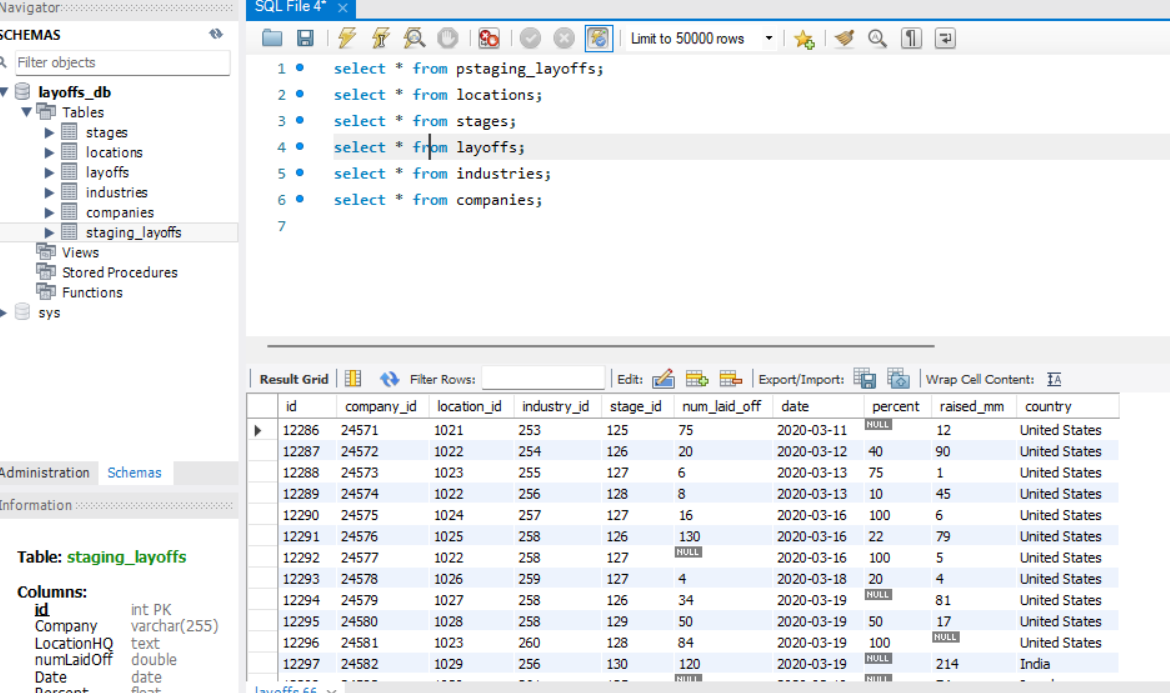
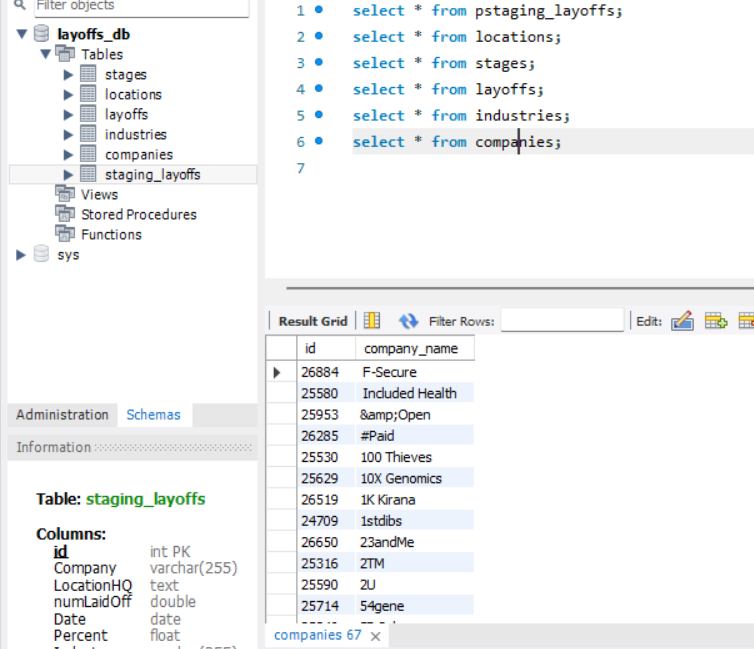


### Now we load the tables in Power BI

This is how are model schema looks

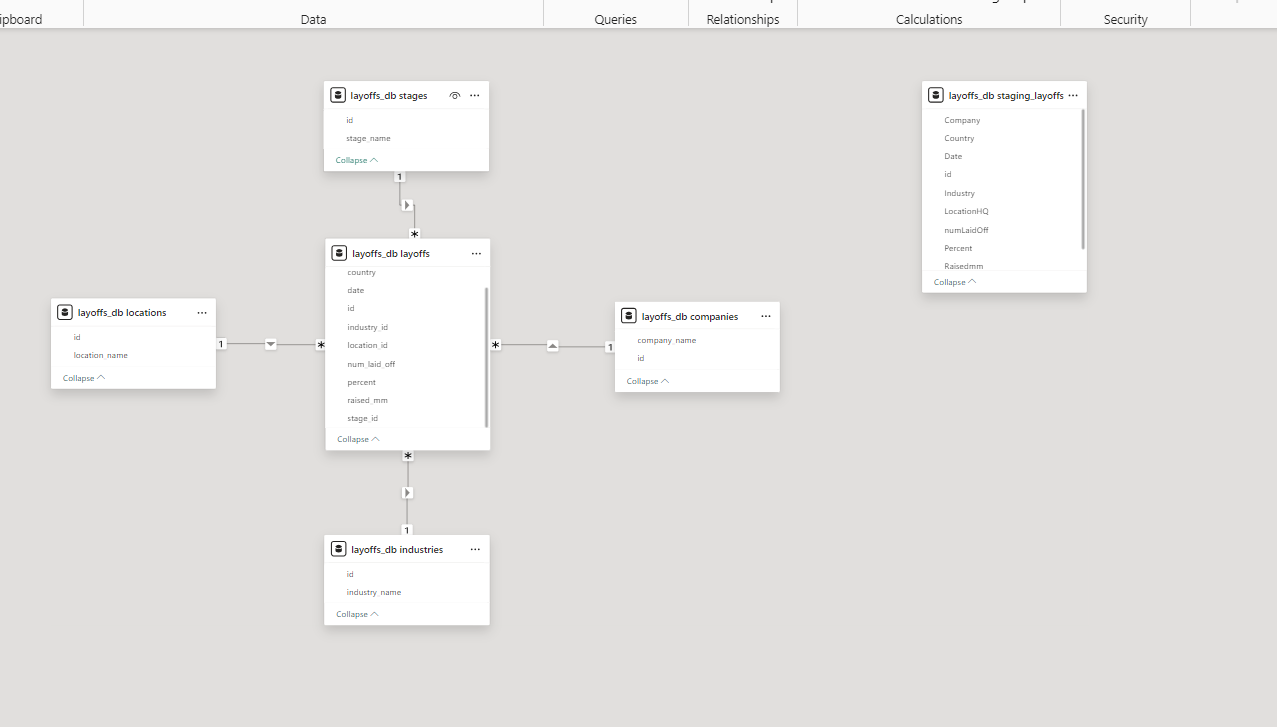

### Finally we create a dashboard where we can quickly monitor some of the data. We can see the layoffs peaked in the first months of 2023. Even though this year they are decreased, the trend is still increasing overall. USA is the leading country with massive layoffs especially from big tech companies. Did they overhire during covid and the previous decade? Is AI automating tech jobs more and more and less people are needed? Is it just a temporary phenomenon and the market will recover?
### The next goal is to keep track on the layoffs for the years to come and have a database available for analysts to work. 


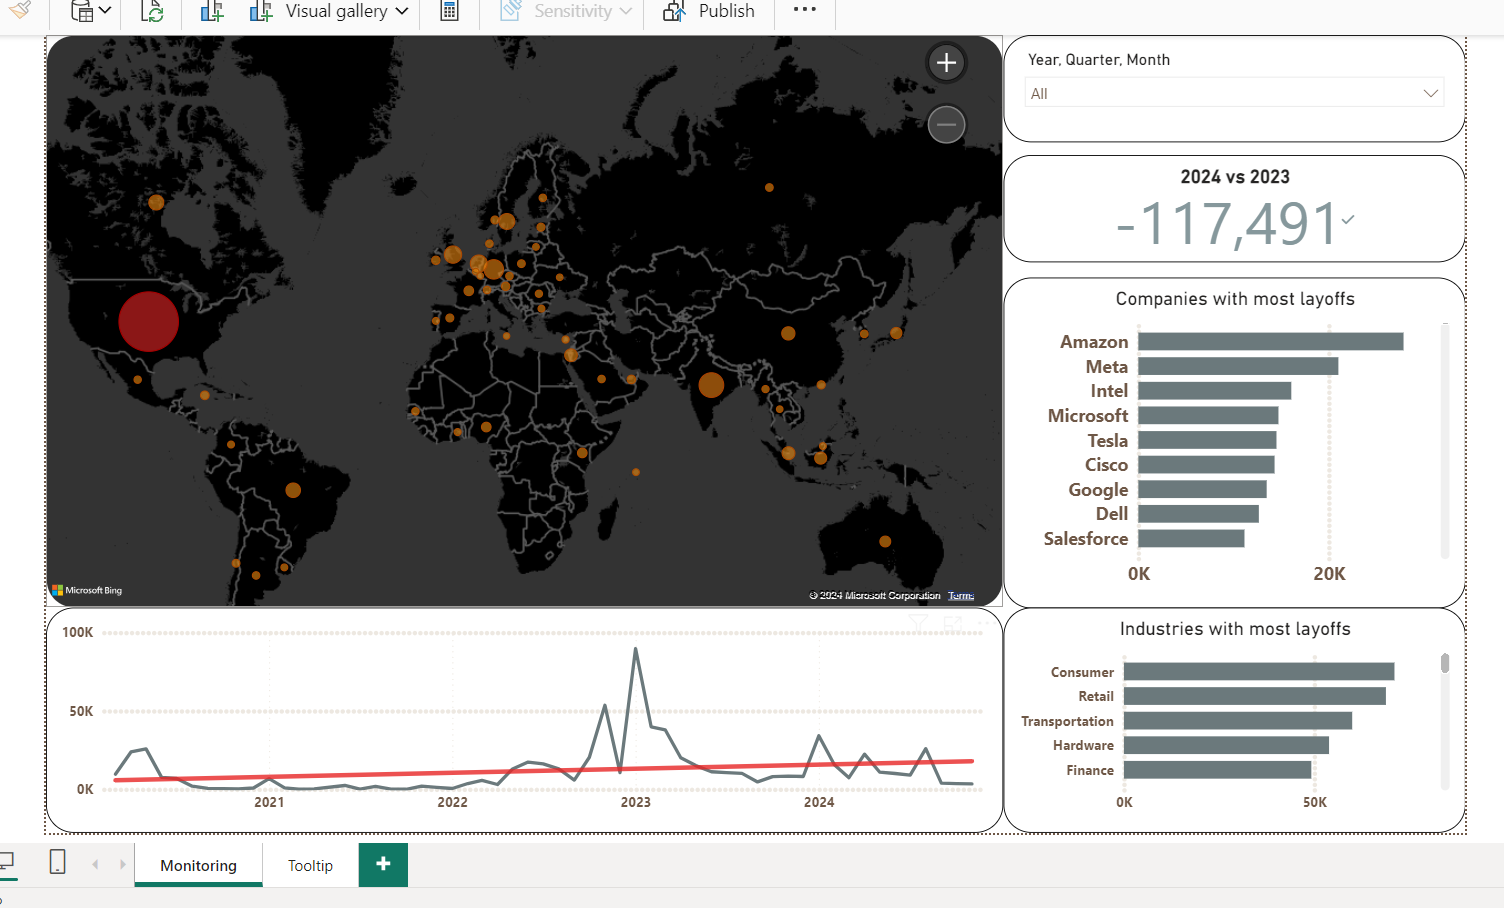
